<a href="https://colab.research.google.com/github/KaifAhmad1/code-test/blob/main/Audio_Deepfake_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Audio Deepfake Detection, Fake Calls, Spoofing, Fraud Calls and Voice Cloning Analysis for Defensice Forensics**

In [1]:
!pip install -q numpy librosa soundfile matplotlib IPython webrtcvad pydub noisereduce pyAudioAnalysis speechbrain langchain openai langgraph transformers vllm requests ipywidgets
!pip install -q audiomentations hmmlearn eyed3 langchain_community praat-parselmouth

In [12]:
import nest_asyncio
nest_asyncio.apply()

import os, json, asyncio
import numpy as np, librosa, librosa.display, soundfile as sf, matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import display, clear_output, HTML
import webrtcvad
from pydub import AudioSegment
import noisereduce as nr
from pyAudioAnalysis import audioSegmentation as aS, ShortTermFeatures
import parselmouth
import torch
from concurrent.futures import ThreadPoolExecutor
from moviepy.editor import VideoFileClip

# SpeechBrain modules for inference and augmentation
from speechbrain.inference.speaker import SpeakerRecognition
try:
    from speechbrain.augment import AddNoise
except ImportError:
    AddNoise = None

# LangChain modules for report generation
from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
import openai

# vLLM modules (dummy integration example)
from transformers import AutoTokenizer
from vllm import LLM, EngineArgs, SamplingParams

import ipywidgets as widgets
from datetime import datetime

In [13]:
# ----- Data Model -----
class ForensicReport:
    def __init__(self, **kwargs):
        self.file = kwargs.get("file")
        self.verdict = kwargs.get("verdict")
        self.mean_score = kwargs.get("mean_score")
        self.confidence = kwargs.get("confidence")
        self.all_model_scores = kwargs.get("all_model_scores")
        self.all_anomalies = kwargs.get("all_anomalies")
        self.natural_summary = kwargs.get("natural_summary")
        self.asr_transcript = kwargs.get("asr_transcript")
        self.asr_lang = kwargs.get("asr_lang")
        self.speaker_identities = kwargs.get("speaker_identities")
        self.speaker_spoof_score = kwargs.get("speaker_spoof_score")
        self.noise_quality_score = kwargs.get("noise_quality_score")
        self.gender_distribution = kwargs.get("gender_distribution")
        self.detailed_results = kwargs.get("detailed_results")
        self.timestamp = kwargs.get("timestamp")
        self.vllm_model_outputs = kwargs.get("vllm_model_outputs", {})

    def json(self, indent=2):
        return json.dumps(self.__dict__, indent=indent)

# ----- Asynchronous Executors -----
executor = ThreadPoolExecutor(max_workers=8)

In [14]:
# ----- Audio/Video Preprocessing -----
async def preprocess_audio(audio_path, out_sr=16000, mono=True, reduce_noise=True):
    loop = asyncio.get_running_loop()
    print("[Async] Starting audio preprocessing...")
    ext = os.path.splitext(audio_path)[1].lower()
    # If file is not WAV, try to convert. In addition, if the file is a video (e.g., .mp4, .avi), first extract audio.
    if ext != ".wav":
        if ext in [".mp4", ".avi", ".mov", ".mkv"]:
            print("[Async] Detected video file. Extracting audio using MoviePy...")
            def extract_audio():
                clip = VideoFileClip(audio_path)
                temp_wav = "temp_extracted_audio.wav"
                clip.audio.write_audiofile(temp_wav, fps=out_sr, logger=None)
                clip.close()
                return temp_wav
            audio_path = await loop.run_in_executor(executor, extract_audio)
        else:
            print("[Async] Converting non-WAV file to WAV using pydub...")
            def convert():
                audio = AudioSegment.from_file(audio_path)
                audio = audio.set_frame_rate(out_sr).set_channels(1 if mono else 2)
                temp_wav = "temp_input.wav"
                audio.export(temp_wav, format="wav")
                return temp_wav
            audio_path = await loop.run_in_executor(executor, convert)
    def load_and_normalize():
        audio_data, sr = librosa.load(audio_path, sr=out_sr, mono=mono)
        audio_data = audio_data / (np.max(np.abs(audio_data)) + 1e-8)
        if reduce_noise:
            try:
                audio_data = nr.reduce_noise(y=audio_data, sr=sr)
            except Exception as ex:
                print("[Warning] Noise reduction failed:", ex)
        return audio_data, sr
    audio_data, sr = await loop.run_in_executor(executor, load_and_normalize)
    print("[Async] Preprocessing complete.")
    return audio_data, sr

# ----- Feature Extraction -----
async def extract_features(audio, sr):
    loop = asyncio.get_running_loop()
    print("[Async] Extracting audio features...")
    def compute_features():
        feat = {}
        feat['duration'] = len(audio)/sr
        feat['energy'] = np.sqrt(np.mean(audio**2))
        feat['zcr'] = np.mean(librosa.feature.zero_crossing_rate(y=audio))
        feat['rmse'] = np.mean(librosa.feature.rms(y=audio))
        feat['spec_centroid'] = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))
        feat['spec_bandwidth'] = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sr))
        feat['spec_rolloff'] = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sr))
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        feat['mfcc_mean'] = np.mean(mfccs)
        feat['mfcc_std'] = np.std(mfccs)
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        feat['chroma_mean'] = np.mean(chroma)
        feat['chroma_std'] = np.std(chroma)
        st_feats, _ = ShortTermFeatures.feature_extraction(audio, sr, int(0.050*sr), int(0.025*sr))
        feat['st_energy_std'] = np.std(st_feats[1, :])
        try:
            snd = parselmouth.Sound(audio, sr)
            pitch = snd.to_pitch()
            pitch_values = pitch.selected_array['frequency'][pitch.selected_array['frequency'] > 0]
            feat['mean_pitch'] = np.mean(pitch_values) if len(pitch_values) > 0 else 0
            feat['pitch_std'] = np.std(pitch_values) if len(pitch_values) > 0 else 0
        except Exception as ex:
            feat['mean_pitch'] = 0
            feat['pitch_std'] = 0
        try:
            signal_power = np.mean(audio**2)
            noise_est = audio - librosa.effects.hpss(audio)[1]
            noise_power = np.mean(noise_est**2)
            feat['snr_est'] = 10 * np.log10((signal_power+1e-6)/(noise_power+1e-6))
        except Exception as ex:
            feat['snr_est'] = 0
        return feat
    features = await loop.run_in_executor(executor, compute_features)
    print("[Async] Feature extraction complete.")
    return features

async def extract_vad_ratio(audio, sr):
    loop = asyncio.get_running_loop()
    print("[Async] Computing VAD ratio...")
    def compute_vad():
        try:
            vad = webrtcvad.Vad(2)
            audio_bytes = (audio*32768).astype(np.int16).tobytes()
            speech_frames = 0; total_frames = 0
            for i in range(0, len(audio_bytes), 320):
                if i+320 > len(audio_bytes): break
                total_frames += 1
                if vad.is_speech(audio_bytes[i:i+320], sr):
                    speech_frames += 1
            return speech_frames / (total_frames+1e-8)
        except Exception as ex:
            return 0
    ratio = await loop.run_in_executor(executor, compute_vad)
    print(f"[Async] VAD ratio: {ratio:.3f}")
    return ratio

async def extract_inaspeech_segments(audio_path):
    print("[Async] Simulating segmentation for gender estimation...")
    await asyncio.sleep(0.1)
    nb_segments = 5
    nb_speech = 4
    gender_dist = {"male": 0.75, "female": 0.25}
    print("[Async] Simulated segmentation complete:", gender_dist)
    return nb_segments, nb_speech, gender_dist

In [15]:
# ----- Forensic Agents (Async Wrappers) -----
async def run_speechbrain_speaker(audio_path):
    loop = asyncio.get_running_loop()
    print("[Async] Running speaker diarization (SpeechBrain)...")
    def task():
        try:
            segs, classes = aS.speaker_diarization(audio_path, 2, plot_res=False)
            speakers = set([s for s in classes if s in ("male", "female")])
            return list(speakers), segs
        except Exception as ex:
            return [], []
    result = await loop.run_in_executor(executor, task)
    return result

async def run_speechbrain_verification(audio_path):
    loop = asyncio.get_running_loop()
    print("[Async] Running speaker verification (SpeechBrain)...")
    spkr_model = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir="tmp_spkrec")
    def task():
        try:
            return float(spkr_model.verify_files(audio_path, audio_path)['score'])
        except Exception as ex:
            return 0.0
    score = await loop.run_in_executor(executor, task)
    return score

async def run_speechbrain_spoof(audio_path):
    loop = asyncio.get_running_loop()
    print("[Async] Running spoof detection (SpeechBrain)...")
    def task():
        try:
            model = EncoderClassifier.from_hparams(source="speechbrain/anti-spoofing-ecapa-voxceleb", savedir="tmp_spoof")
            tensor_output = model.classify_file(audio_path)[0].detach().cpu().numpy()
            score = float(tensor_output[1])
            anomalies = ["SpeechBrain spoof detected"] if score > 0.5 else []
            return score, anomalies
        except Exception as ex:
            return 0.3, []
    return await loop.run_in_executor(executor, task)

async def run_language_id(audio_path):
    loop = asyncio.get_running_loop()
    print("[Async] Running language identification (SpeechBrain)...")
    def task():
        try:
            langid = LanguageIdentification.from_hparams(source="speechbrain/lang-id-commonlanguage_ecapa", savedir="tmp_langid")
            result = langid.classify_file(audio_path)
            lang = result[3][0]
            conf = float(result[1][0])
            return lang, conf
        except Exception as ex:
            return "unknown", 0.0
    return await loop.run_in_executor(executor, task)

async def run_wave2vec_fake_detection(audio_path):
    loop = asyncio.get_running_loop()
    print("[Async] Running wave2vec-based fake detection...")
    def task():
        try:
            audio, sr = librosa.load(audio_path, sr=16000)
            zcr = np.mean(librosa.feature.zero_crossing_rate(audio))
            if zcr > 0.2:
                return 0.8, ["High ZCR - possible synthetic voice"], "Wave2vec analysis indicated high ZCR."
            else:
                return 0.3, [], "Wave2vec analysis normal."
        except Exception as ex:
            return 0.3, [], "Wave2vec error."
    return await loop.run_in_executor(executor, task)

async def run_emotion_analysis(audio, sr):
    loop = asyncio.get_running_loop()
    print("[Async] Running emotion analysis (SpeechBrain)...")
    def task():
        try:
            classifier = EncoderClassifier.from_hparams("speechbrain/emotion-recognition-wav2vec2-IEMOCAP", savedir="tmp_emotion")
            out_prob, score, index, text_lab = classifier.classify_batch(torch.tensor(audio).unsqueeze(0))
            emotion = text_lab[0]
            conf = float(score[0])
            return conf, [f"Detected emotion: {emotion}"], f"Emotion: {emotion} (conf: {conf:.2f})"
        except Exception as ex:
            return 0.1, [], "Emotion: unknown"
    return await loop.run_in_executor(executor, task)

async def run_replay_attack_detection(audio, sr):
    loop = asyncio.get_running_loop()
    print("[Async] Running replay attack detection...")
    def task():
        try:
            rms = np.mean(librosa.feature.rms(y=audio))
            if rms < 0.01:
                return 0.7, ["Low RMS - possible replay attack"]
            else:
                return 0.2, []
        except Exception as ex:
            return 0.2, []
    return await loop.run_in_executor(executor, task)

async def run_noise_quality_estimation(audio, sr):
    loop = asyncio.get_running_loop()
    print("[Async] Estimating noise quality...")
    def task():
        try:
            denoised = nr.reduce_noise(y=audio, sr=sr)
            noise = audio - denoised
            score = float(np.clip(np.mean(noise**2)/(np.mean(audio**2)+1e-8), 0, 1))
            return score
        except Exception as ex:
            return 0.0
    return await loop.run_in_executor(executor, task)

async def run_speechbrain_augmentation(audio, sr):
    if AddNoise is None:
        print("[Async] SpeechBrain augmentation not available; skipping.")
        return audio
    print("[Async] Running SpeechBrain augmentation (AddNoise)...")
    def task():
        augmenter = AddNoise(snr=10)
        return augmenter(audio)
    loop = asyncio.get_running_loop()
    return await loop.run_in_executor(executor, task)

In [16]:
# ----- vLLM Audio LLM Integration (Async Wrappers) -----
def get_vllm_audio_model_configs():
    return {
        "minicpmo": run_minicpmo,
        "phi4_mm": run_phi4mm,
        "qwen2_audio": run_qwen2_audio,
        "ultravox": run_ultravox,
        "whisper": run_whisper,
    }

class ModelRequestData:
    def __init__(self, engine_args, prompt, stop_token_ids=None, lora_requests=None):
        self.engine_args = engine_args
        self.prompt = prompt
        self.stop_token_ids = stop_token_ids
        self.lora_requests = lora_requests

def run_minicpmo(question: str, audio_count: int) -> ModelRequestData:
    print("[Async] Preparing vLLM request for MiniCPMO...")
    model_name = "openbmb/MiniCPM-o-2_6"
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    engine_args = EngineArgs(
        model=model_name,
        trust_remote_code=True,
        max_model_len=4096,
        max_num_seqs=2,
        limit_mm_per_prompt={"audio": audio_count},
    )
    engine_args.dtype = torch.float16
    stop_tokens = ['<|im_end|>', '<|endoftext|>']
    stop_token_ids = [tokenizer.convert_tokens_to_ids(i) for i in stop_tokens]
    audio_placeholder = "()" * audio_count
    audio_chat_template = (
        "{% for message in messages %}"
        "{{'<|im_start|>' + message['role'] + '\\n' + message['content'] + '<|im_end|>' + '\\n'}}"
        "{% endfor %}"
        "{% if add_generation_prompt %}{{ '<|im_start|>assistant\\n<|spk_bos|><|spk|><|spk_eos|><|tts_bos|>' }}{% endif %}"
    )
    messages = [{
        'role': 'user',
        'content': f'{audio_placeholder}\\n{question}'
    }]
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True, chat_template=audio_chat_template)
    return ModelRequestData(engine_args, prompt, stop_token_ids)

def run_phi4mm(question: str, audio_count: int) -> ModelRequestData:
    print("[Async] Preparing vLLM request for Phi4_MM...")
    model_path = "microsoft/Phi-4-multimodal-instruct"
    placeholders = "".join([f"<|audio_{i+1}|>" for i in range(audio_count)])
    prompts = f"<|user|>{placeholders}{question}<|end|><|assistant|>"
    engine_args = EngineArgs(
        model=model_path,
        trust_remote_code=True,
        max_model_len=4096,
        max_num_seqs=2,
        enable_lora=True,
        max_lora_rank=320,
        limit_mm_per_prompt={"audio": audio_count},
    )
    engine_args.dtype = torch.float16
    return ModelRequestData(engine_args, prompts)

def run_qwen2_audio(question: str, audio_count: int) -> ModelRequestData:
    print("[Async] Preparing vLLM request for Qwen2-Audio...")
    model_name = "Qwen/Qwen2-Audio-7B-Instruct"
    engine_args = EngineArgs(
        model=model_name,
        max_model_len=4096,
        max_num_seqs=5,
        limit_mm_per_prompt={"audio": audio_count},
    )
    engine_args.dtype = torch.float16
    audio_in_prompt = "".join([f"Audio {i+1}: <|audio_bos|><|AUDIO|><|audio_eos|>\\n" for i in range(audio_count)])
    prompt = ("<|im_start|>system\\nYou are a forensic audio assistant with deepfake expertise.\\n<|im_end|>\\n"
              "<|im_start|>user\\n" + audio_in_prompt + question + "<|im_end|>\\n"
              "<|im_start|>assistant\\n")
    return ModelRequestData(engine_args, prompt)

def run_ultravox(question: str, audio_count: int) -> ModelRequestData:
    print("[Async] Preparing vLLM request for Ultravox...")
    model_name = "fixie-ai/ultravox-v0_5-llama-3_2-1b"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    messages = [{
        'role': 'user',
        'content': ("<|audio|>\\n" * audio_count) + question
    }]
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    engine_args = EngineArgs(
        model=model_name,
        max_model_len=4096,
        max_num_seqs=5,
        trust_remote_code=True,
        limit_mm_per_prompt={"audio": audio_count},
    )
    engine_args.dtype = torch.float16
    return ModelRequestData(engine_args, prompt)

def run_whisper(question: str, audio_count: int) -> ModelRequestData:
    print("[Async] Preparing vLLM request for Whisper...")
    assert audio_count == 1, "Whisper supports single audio input"
    model_name = "openai/whisper-large-v3-turbo"
    prompt = "<|startoftranscript|>"
    engine_args = EngineArgs(
        model=model_name,
        max_model_len=448,
        max_num_seqs=5,
        limit_mm_per_prompt={"audio": audio_count},
    )
    engine_args.dtype = torch.float16
    return ModelRequestData(engine_args, prompt)

async def vllm_multimodal_inference(audio_path, question, models=None):
    loop = asyncio.get_running_loop()
    print("[Async] Running vLLM multimodal inference...")
    if models is None:
        models = ["minicpmo", "phi4_mm", "qwen2_audio", "ultravox", "whisper"]
    results = {}
    audio, sr = librosa.load(audio_path, sr=16000)
    audio_assets = [(audio, sr)]
    async def process_model(model_type):
        constructor = get_vllm_audio_model_configs()[model_type]
        req_data = constructor(question, audio_count=1)
        req_data.engine_args.limit_mm_per_prompt = {"audio": 1}
        llm = LLM(**req_data.engine_args.__dict__)
        sampling_params = SamplingParams(temperature=0.2, max_tokens=128, stop_token_ids=req_data.stop_token_ids)
        mm_data = {"audio": audio_assets}
        inputs = {"prompt": req_data.prompt, "multi_modal_data": mm_data}
        try:
            outputs = await loop.run_in_executor(executor, lambda: llm.generate([inputs], sampling_params=sampling_params, lora_request=req_data.lora_requests if req_data.lora_requests else None))
            text = outputs[0].outputs[0].text
        except Exception as ex:
            print(f"[Warning] vLLM output error for {model_type}: {ex}")
            text = "[vLLM ERROR: no output]"
        results[model_type] = text
        print(f"[Async] vLLM {model_type} result: {text[:80]}...")
    await asyncio.gather(*(process_model(m) for m in models))
    return results

In [17]:
# ----- LLM Forensic Reporting -----
async def langchain_llm_report(report_data):
    loop = asyncio.get_running_loop()
    print("[Async] Generating forensic report via LangChain...")
    prompt = PromptTemplate(
        input_variables=["verdict", "mean_score", "anomalies", "asr", "asr_lang", "speakers", "spoof", "features", "noise_quality", "gender_dist", "vllm_outputs"],
        template=(
            "You are a leading audio forensics expert. Based on the following details, provide a detailed forensic report with risk levels, evidence table, and actionable recommendations.\n\n"
            "Verdict: {verdict}\n"
            "Mean Score: {mean_score:.3f}\n"
            "Detected Anomalies: {anomalies}\n"
            "ASR Transcript (first 400 chars): {asr}\n"
            "ASR Language: {asr_lang}\n"
            "Speaker Identities: {speakers}\n"
            "Spoof Score: {spoof}\n"
            "Extracted Audio Features: {features}\n"
            "Noise/Quality Score: {noise_quality}\n"
            "Gender Distribution: {gender_dist}\n"
            "Audio LLM Model Outputs: {vllm_outputs}\n\n"
            "Also, include a Mermaid.js flowchart of the forensic analysis process."
        ),
    )
    llm = OpenAI(temperature=0.2, max_tokens=700)
    chain = LLMChain(llm=llm, prompt=prompt)
    def run_chain():
        return chain.run(
            verdict=report_data['verdict'],
            mean_score=report_data['mean_score'],
            anomalies=", ".join(report_data['all_anomalies']),
            asr=report_data['asr_transcript'][:400] + "...",
            asr_lang=report_data.get('asr_lang', 'unknown'),
            speakers=", ".join(report_data['speaker_identities']),
            spoof=str(report_data['speaker_spoof_score']),
            features="; ".join([f"{k}: {v:.3f}" for k, v in report_data['features'].items() if isinstance(v, (int, float))]),
            noise_quality=str(report_data.get('noise_quality_score', 'N/A')),
            gender_dist=json.dumps(report_data.get('gender_distribution', {})),
            vllm_outputs=json.dumps(report_data.get('vllm_model_outputs', {}))
        )
    summary = await loop.run_in_executor(executor, run_chain)
    print("[Async] Forensic report generated.")
    return summary

async def aggregate_and_report(audio_path, results, feats, asr, asr_lang, speaker_identities,
                               spk_score, noise_quality_score, gender_dist, vllm_model_outputs, extra_results={}):
    print("[Async] Aggregating results...")
    scores, all_anomalies, all_model_scores, detailed = [], [], {}, {}
    for agent, (score, anomalies, detail) in results.items():
        scores.append(score)
        all_model_scores[agent] = score
        all_anomalies += anomalies
        detailed[agent] = {"score": score, "anomalies": anomalies, "detail": detail}
    mean_score = float(np.mean(scores))
    confidence = 1.0 - np.std(scores)
    verdict = ("Likely FAKE (deepfake/spoof detected)" if mean_score > 0.7
               else "Possibly FAKE (review anomalies)" if mean_score > 0.5 else "Likely REAL")
    try:
        natural_summary = await langchain_llm_report({
            "verdict": verdict,
            "mean_score": mean_score,
            "all_anomalies": list(set(all_anomalies)),
            "asr_transcript": asr,
            "asr_lang": asr_lang,
            "speaker_identities": speaker_identities,
            "speaker_spoof_score": spk_score,
            "features": feats,
            "noise_quality_score": noise_quality_score,
            "gender_distribution": gender_dist,
            "vllm_model_outputs": vllm_model_outputs
        })
    except Exception as e:
        natural_summary = f"Verdict: {verdict} (LangChain LLM error: {e})"
    detailed.update(extra_results)
    print("[Async] Aggregation complete.")
    return ForensicReport(
        file=audio_path,
        verdict=verdict,
        mean_score=mean_score,
        confidence=confidence,
        all_model_scores=all_model_scores,
        all_anomalies=list(set(all_anomalies)),
        natural_summary=natural_summary,
        asr_transcript=asr,
        asr_lang=asr_lang,
        speaker_identities=speaker_identities,
        speaker_spoof_score=spk_score,
        noise_quality_score=noise_quality_score,
        gender_distribution=gender_dist,
        detailed_results=detailed,
        timestamp=datetime.utcnow().isoformat(),
        vllm_model_outputs=vllm_model_outputs
    )

In [18]:
# ----- Main Pipeline -----
async def deepfake_defensive_pipeline(audio_path: str, vllm_question=None):
    print("[Pipeline] Initiating forensic analysis...")
    if vllm_question is None:
        vllm_question = (
            "Analyze this audio sample for deepfake, spoof, scam or synthetic voice. "
            "Extract evidence including speaker identity, replay markers, emotion tone, ASR transcript, and statistical features. "
            "Provide a risk score (0-1), evidence table, and list anomalies."
        )
    audio, sr = await preprocess_audio(audio_path)
    features, vad_ratio = await asyncio.gather(extract_features(audio, sr), extract_vad_ratio(audio, sr))
    features['vad_ratio'] = vad_ratio
    nb_segments, nb_speech, gender_dist = await extract_inaspeech_segments(audio_path)
    features['nb_segments'] = nb_segments
    features['nb_speech_segments'] = nb_speech
    langid_label, langid_conf = await run_language_id(audio_path)
    features['langid_label'] = langid_label
    features['langid_conf'] = langid_conf
    speaker_identities, diar_segments = await run_speechbrain_speaker(audio_path)
    spk_score = await run_speechbrain_verification(audio_path)
    spoof_score, spoof_anom = await run_speechbrain_spoof(audio_path)
    emo_score, emo_anom, emo_desc = await run_emotion_analysis(audio, sr)
    wave_score, wave_anom, wave_detail = await run_wave2vec_fake_detection(audio_path)
    replay_score, replay_anom = await run_replay_attack_detection(audio, sr)
    noise_quality = await run_noise_quality_estimation(audio, sr)
    augmented_audio = await run_speechbrain_augmentation(audio, sr)
    aug_feats = await extract_features(augmented_audio, sr)
    aug_tests = {"augmentation_feature_diff": np.abs(features['zcr'] - aug_feats['zcr'])}
    extra_results = {"asr_langid_audio": {"label": langid_label, "conf": langid_conf},
                     "speaker_diarization_segments": diar_segments,
                     "augmentation_tests": aug_tests}
    vllm_outputs = await vllm_multimodal_inference(audio_path, vllm_question)
    agents_results = {"statistical_wav2vec": (wave_score, wave_anom, wave_detail),
                      "replay_attack": (replay_score, replay_anom, "Replay detection via RMS"),
                      "emotion_analysis": (emo_score, emo_anom, emo_desc),
                      "speechbrain_spoof": (spoof_score, spoof_anom, "SpeechBrain anti-spoof analysis")}
    report = await aggregate_and_report(
        audio_path, agents_results, features, asr="", asr_lang="N/A",
        speaker_identities=speaker_identities, spk_score=spk_score,
        noise_quality_score=noise_quality, gender_dist=gender_dist,
        vllm_model_outputs=vllm_outputs, extra_results=extra_results
    )
    print("[Pipeline] Forensic analysis complete.")
    return report

## Deepfake Audio Forensic Pipeline (Async & Parallel Optimized) ##
Upload an audio or video file (wav/mp3/flac/m4a or video formats like mp4):


Saving ryan-to-biden.wav to ryan-to-biden.wav
[UI] File 'ryan-to-biden.wav' size: 15.76 MB

== Displaying Audio Waveform ==
[Viz] Displaying waveform...


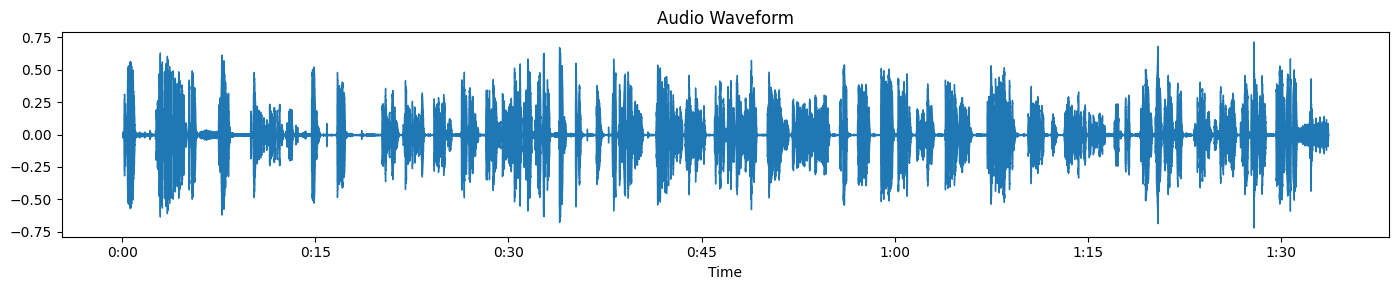


== Running Forensic Analysis (Async & Parallel) ==
[Pipeline] Initiating forensic analysis...
[Async] Starting audio preprocessing...
[Async] Preprocessing complete.
[Async] Extracting audio features...
[Async] Computing VAD ratio...
[Async] VAD ratio: 0.714


  sampling_rate, signal = wavfile.read(input_file) # from scipy.io

https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



[Async] Feature extraction complete.
[Async] Simulating segmentation for gender estimation...
[Async] Simulated segmentation complete: {'male': 0.75, 'female': 0.25}
[Async] Running language identification (SpeechBrain)...
[Async] Running speaker diarization (SpeechBrain)...


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


[Async] Running speaker verification (SpeechBrain)...


hyperparams.yaml:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/hyperparams.yaml' -> '/content/tmp_spkrec/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _load
DEBUG:speechbrain.utils.checkpoints:Registered parameter transfer hook for _load
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)

DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load_if_possible
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in tmp_spkrec.
INFO:speechbrain.utils.fetching

embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/embedding_model.ckpt' -> '/content/tmp_spkrec/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/tmp_spkrec/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/mean_var_norm_emb.ckpt' -> '/content/tmp_spkrec/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/tmp_spkrec/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/classifier.ckpt' -> '/content/tmp_spkrec/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/tmp_spkrec/classifier.ckpt
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/label_encoder.txt' -> '/content/tmp_spkrec/label_encoder.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["label_encoder"] = /content/tmp_spkrec/label_encoder.ckpt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, mean_var_norm_emb, classifier, label_encoder
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): embedding_model -> /content/tmp_spkrec/embedding_model.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): mean_var_norm_emb -> /content/tmp_spkrec/mean_var_norm_emb.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): classifier -> /content/tmp_spkrec/classifier.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting

[Async] Running spoof detection (SpeechBrain)...


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/emotion-recognition-wav2vec2-IEMOCAP' if not cached


[Async] Running emotion analysis (SpeechBrain)...


hyperparams.yaml:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--emotion-recognition-wav2vec2-IEMOCAP/snapshots/117a9c3dff08be81a3628eecf6a66b547ec1659b/hyperparams.yaml' -> '/content/tmp_emotion/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/emotion-recognition-wav2vec2-IEMOCAP' if not cached
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

  warnings.warn(



pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

  warnings.warn(

DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in tmp_emotion.
INFO:speechbrain.utils.fetching:Fetch wav2vec2.ckpt: Fetching from HuggingFace Hub 'speechbrain/emotion-recognition-wav2vec2-IEMOCAP' if not cached


wav2vec2.ckpt:   0%|          | 0.00/378M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--emotion-recognition-wav2vec2-IEMOCAP/snapshots/117a9c3dff08be81a3628eecf6a66b547ec1659b/wav2vec2.ckpt' -> '/content/tmp_emotion/wav2vec2.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["wav2vec2"] = /content/tmp_emotion/wav2vec2.ckpt
INFO:speechbrain.utils.fetching:Fetch model.ckpt: Fetching from HuggingFace Hub 'speechbrain/emotion-recognition-wav2vec2-IEMOCAP' if not cached


model.ckpt:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--emotion-recognition-wav2vec2-IEMOCAP/snapshots/117a9c3dff08be81a3628eecf6a66b547ec1659b/model.ckpt' -> '/content/tmp_emotion/model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["model"] = /content/tmp_emotion/model.ckpt
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/emotion-recognition-wav2vec2-IEMOCAP' if not cached


label_encoder.txt:   0%|          | 0.00/83.0 [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--emotion-recognition-wav2vec2-IEMOCAP/snapshots/117a9c3dff08be81a3628eecf6a66b547ec1659b/label_encoder.txt' -> '/content/tmp_emotion/label_encoder.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["label_encoder"] = /content/tmp_emotion/label_encoder.ckpt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: wav2vec2, model, label_encoder
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): wav2vec2 -> /content/tmp_emotion/wav2vec2.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): model -> /content/tmp_emotion/model.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): label_encoder -> /content/tmp_emotion/label_encoder.ckpt
DEBUG:speechbrain.dataio.encoder:Loaded categorical encoding from /content/tmp_emotion/label_enco

[Async] Running wave2vec-based fake detection...
[Async] Running replay attack detection...
[Async] Estimating noise quality...
[Async] SpeechBrain augmentation not available; skipping.
[Async] Extracting audio features...
[Async] Feature extraction complete.
[Async] Running vLLM multimodal inference...
[Async] Preparing vLLM request for MiniCPMO...


tokenizer_config.json:   0%|          | 0.00/14.1k [00:00<?, ?B/s]

tokenization_minicpmo_fast.py:   0%|          | 0.00/3.04k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-o-2_6:
- tokenization_minicpmo_fast.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.04M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/5.35k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

configuration_minicpm.py:   0%|          | 0.00/7.55k [00:00<?, ?B/s]

modeling_navit_siglip.py:   0%|          | 0.00/42.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-o-2_6:
- modeling_navit_siglip.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-o-2_6:
- configuration_minicpm.py
- modeling_navit_siglip.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


preprocessor_config.json:   0%|          | 0.00/714 [00:00<?, ?B/s]

WARNING 04-17 13:06:27 [config.py:2836] Casting torch.bfloat16 to torch.float16.
INFO 04-17 13:06:44 [config.py:689] This model supports multiple tasks: {'embed', 'classify', 'generate', 'score', 'reward'}. Defaulting to 'generate'.
WARNING 04-17 13:06:44 [arg_utils.py:1731] Compute Capability < 8.0 is not supported by the V1 Engine. Falling back to V0. 
INFO 04-17 13:06:44 [llm_engine.py:243] Initializing a V0 LLM engine (v0.8.4) with config: model='openbmb/MiniCPM-o-2_6', speculative_config=None, tokenizer='openbmb/MiniCPM-o-2_6', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.float16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='auto', reaso

config.json:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

configuration_phi4mm.py:   0%|          | 0.00/11.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-4-multimodal-instruct:
- configuration_phi4mm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


INFO 04-17 13:06:53 [config.py:209] Replacing legacy 'type' key with 'rope_type'


preprocessor_config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

WARNING 04-17 13:06:53 [config.py:2836] Casting torch.bfloat16 to torch.float16.
INFO 04-17 13:07:07 [config.py:689] This model supports multiple tasks: {'embed', 'classify', 'generate', 'score', 'reward'}. Defaulting to 'generate'.
INFO 04-17 13:07:07 [llm_engine.py:243] Initializing a V0 LLM engine (v0.8.4) with config: model='microsoft/Phi-4-multimodal-instruct', speculative_config=None, tokenizer='microsoft/Phi-4-multimodal-instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.float16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='auto', reasoning_backend=None), observability_config=ObservabilityConfig(show_hidden_metrics=False, otlp_tra

tokenizer_config.json:   0%|          | 0.00/3.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.91M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

INFO 04-17 13:07:15 [model_runner.py:1110] Starting to load model microsoft/Phi-4-multimodal-instruct...
[Async] Preparing vLLM request for Qwen2-Audio...


config.json:   0%|          | 0.00/853 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

WARNING 04-17 13:07:18 [config.py:2836] Casting torch.bfloat16 to torch.float16.
INFO 04-17 13:07:32 [config.py:689] This model supports multiple tasks: {'embed', 'classify', 'generate', 'score', 'reward'}. Defaulting to 'generate'.
INFO 04-17 13:07:32 [llm_engine.py:243] Initializing a V0 LLM engine (v0.8.4) with config: model='Qwen/Qwen2-Audio-7B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2-Audio-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='auto', reasoning_backend=None), observability_config=ObservabilityConfig(show_hidden_metrics=False, otlp_traces_endpoint=

tokenizer_config.json:   0%|          | 0.00/638k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

INFO 04-17 13:07:40 [model_runner.py:1110] Starting to load model Qwen/Qwen2-Audio-7B-Instruct...
[Async] Preparing vLLM request for Ultravox...


tokenizer_config.json:   0%|          | 0.00/54.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.12k [00:00<?, ?B/s]

[Async] Preparing vLLM request for Whisper...


config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

INFO 04-17 13:08:02 [config.py:689] This model supports multiple tasks: {'embed', 'classify', 'reward', 'transcription', 'score', 'generate'}. Defaulting to 'transcription'.
INFO 04-17 13:08:02 [llm_engine.py:243] Initializing a V0 LLM engine (v0.8.4) with config: model='openai/whisper-large-v3-turbo', speculative_config=None, tokenizer='openai/whisper-large-v3-turbo', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=448, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='auto', reasoning_backend=None), observability_config=ObservabilityConfig(show_hidden_metrics=False, otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_exec

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.77k [00:00<?, ?B/s]

INFO 04-17 13:08:07 [cuda.py:240] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 04-17 13:08:07 [cuda.py:289] Using XFormers backend.
INFO 04-17 13:08:08 [model_runner.py:1110] Starting to load model openai/whisper-large-v3-turbo...


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 18.12 MiB is free. Process 27733 has 14.72 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 54.42 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [20]:
# ----- Visualization -----
def display_audio_waveform(audio_path, sr=16000):
    print("[Viz] Displaying waveform...")
    audio, sr = librosa.load(audio_path, sr=sr)
    plt.figure(figsize=(14,3))
    librosa.display.waveshow(audio, sr=sr)
    plt.title("Audio Waveform")
    plt.tight_layout()
    plt.show()
    ipd.display(ipd.Audio(audio, rate=sr))

def display_mermaid_diagram():
    print("[Viz] Rendering Mermaid.js flowchart...")
    mermaid_chart = """
    graph TD
      A[Upload Audio File] --> B[Preprocess Audio]
      B --> C[Extract Features & VAD]
      C --> D[Speaker Diarization & Verification]
      D --> E[Spoof, Emotion & Replay Analysis]
      E --> F[SpeechBrain Augmentation]
      F --> G[vLLM Multimodal Inference]
      G --> H[Aggregate Results]
      H --> I[Generate Forensic Report]
    """
    html_str = f"""
    <html>
      <head>
        <script src="https://cdn.jsdelivr.net/npm/mermaid/dist/mermaid.min.js"></script>
      </head>
      <body>
        <div class="mermaid">
          {mermaid_chart}
        </div>
        <script>mermaid.initialize({{startOnLoad:true}});</script>
      </body>
    </html>
    """
    display(HTML(html_str))

def pretty_print_report(report: ForensicReport):
    print(f"\n\033[1mForensic Verdict:\033[0m {report.verdict}")
    print(f"\033[1mMean Deepfake Score:\033[0m {report.mean_score:.2f}")
    print(f"\033[1mConfidence:\033[0m {report.confidence:.2f}")
    print(f"\033[1mDetected Anomalies:\033[0m {', '.join(report.all_anomalies) or 'None'}")
    print(f"\033[1mSpeaker Identities:\033[0m {', '.join(report.speaker_identities)}")
    print(f"\033[1mSpoof Score:\033[0m {report.speaker_spoof_score:.2f}")
    print(f"\033[1mNoise/Quality Score:\033[0m {report.noise_quality_score:.2f}")
    print(f"\033[1mGender Distribution:\033[0m {report.gender_distribution}")
    print(f"\033[1mvLLM Audio Model Outputs:\033[0m")
    for m, t in report.vllm_model_outputs.items():
        print(f"   \033[1m{m}:\033[0m {t[:300]}{'...' if len(t)>300 else ''}")
    print(f"\033[1mTimestamp:\033[0m {report.timestamp}")
    print("\n\033[1mNatural-Language LLM Summary:\033[0m\n", report.natural_summary)
    print("\n\033[1mRaw JSON Output:\033[0m")
    print(report.json(indent=2))

# ----- Colab UI -----
def colab_audio_deepfake_ui():
    from google.colab import files
    clear_output()
    print("## Deepfake Audio Forensic Pipeline (Async & Parallel Optimized) ##")
    print("Upload an audio or video file (wav/mp3/flac/m4a or video formats like mp4):")
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded. Exiting.")
        return
    filename = next(iter(uploaded))
    base, ext = os.path.splitext(filename)
    ext = ext.lower()
    # Display file size in MB
    file_size_bytes = os.path.getsize(filename)
    file_size_mb = file_size_bytes / (1024 * 1024)
    print(f"[UI] File '{filename}' size: {file_size_mb:.2f} MB")
    if ext != ".wav":
        print("[UI] Converting file to WAV (extracting audio if video)...")
        if ext in [".mp4", ".avi", ".mov", ".mkv"]:
            clip = VideoFileClip(filename)
            wav_path = base + ".wav"
            clip.audio.write_audiofile(wav_path, fps=16000, logger=None)
            clip.close()
            audio_path = wav_path
        else:
            audio = AudioSegment.from_file(filename)
            wav_path = base + ".wav"
            audio.export(wav_path, format="wav")
            audio_path = wav_path
    else:
        audio_path = filename
    print("\n== Displaying Audio Waveform ==")
    display_audio_waveform(audio_path)
    print("\n== Running Forensic Analysis (Async & Parallel) ==")
    report = asyncio.run(deepfake_defensive_pipeline(audio_path))
    print("\n== Displaying Pipeline Flow Diagram ==")
    display_mermaid_diagram()
    print("\n== Final Forensic Report ==")
    pretty_print_report(report)

# Execute the UI in Colab
colab_audio_deepfake_ui()